# Footprint the extents of raster input and output for SR-Lite

sync to:
/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/notebooks/footprint_srlite.ipynb


In [78]:
!rsync /home/pmontesa/code/geoscitools/footprint_srlite.ipynb /adapt/nobackup/people/pmontesa/userfs02/projects/srlite/notebooks/footprint_srlite.ipynb

In [1]:
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import box
import fiona
from fiona.crs import from_epsg
import pprint

import glob
import os

import sys
sys.path.append('/efs/pmontesa/code/geoscitools')
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import footprintlib
from footprintlib import *

# https://gis.stackexchange.com/questions/375577/how-do-i-write-out-a-mixed-geometry-geodataframe-to-a-geopackage
# https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

### Set up dictionaries of parameters

## Build a dictionary of the raster datasets for footprinting

In [2]:
dict_list = [
    # 3SL Senegal TOAs: /explore/nobackup/projects/3sl/data/VHR
    {'location': 'local',
     'data_dir': '/explore/nobackup/projects/3sl/data',
     'data_source': '3sl',
     'image_type': 'VHR',
     'layer_name': 'P1BS', #M1BS
     'search_tail_string': '/**/*P1BS*toa.tif', #'/**/*M1BS*toa.tif'
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # 3SL Senegal CHMs: /explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1
    {'location': 'local',
     'data_dir': '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal',
     'data_source': '3sl',
     'image_type': 'v1',
     'layer_name': 'toa.2m_chm', #M1BS
     'search_tail_string': '/**/*toa.2m_chm.tif', #'/**/*M1BS*toa.tif'
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # EVHR TOA: /adapt/nobackup/projects/ilab/projects/srlite/input
    {'location': 'local',
     'data_dir': '/explore/nobackup/people/iluser/projects/srlite/input',#'/panfs/ccds02/nobackup/projects/ilab/projects/srlite',#'/explore/nobackup/projects/ilab/data/srlite/toa',#"/adapt/nobackup/projects/ilab/projects/srlite/input/Serc", #/adapt/nobackup/projects/ilab/projects/srlite/input/Serc
     'data_source': 'EVHR',
     'image_type': '**',
     'layer_name': 'M1BS',
     'search_tail_string': '/*M1BS*toa.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/projects/ilab/data/srlite/toa', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # CCDC input: /adapt/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL
    {'location': 'local',
     'data_dir': "/explore/nobackup/people/mmacande/srlite/srlite_shared/ccdc_v20221001", #"/explore/nobackup/projects/ilab/data/srlite/ccdc/ccdc_v20220620",#"/panfs/ccds02/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL",#,#,
     'data_source': 'ccdc_v20221001',#'ccdc_v20220620',#'CCDC',#'',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/*ccdc.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/projects/ilab/data/srlite/ccdc', #'/adapt/nobackup/people/pmontesa/userfs02/_share',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # SR-Lite cloudmasks
    {'location': 'local',
     'data_dir': "/explore/nobackup/projects/ilab/data/srlite/cloudmask",
     'data_source': 'Cloudmask',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/*toa.cloudmask.v1.2.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/projects/ilab/data/srlite/cloudmask',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },

    # SR-lite output
    {'location': 'local',
     #'data_dir': "/adapt/nobackup/projects/ilab/data/srlite/products/srlite-0.9.9-06132022-reproject_ALL_only_once_to_toa",
     #'data_dir': "/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022",
     'data_dir': "/explore/nobackup/projects/ilab/data/srlite/products/archive/srlite-0.9.15-10282022-qa/10282022-all",
     'data_source': 'srlite-0.9.14',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/*sr-02m.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/srlite',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
]

### Run the footprinting code over an datalist to return and geodataframe and a geopackage **updated** 

https://stackoverflow.com/questions/67812512/rasterio-does-not-exist-in-the-file-system-and-is-not-recognized-as-a-support

In [3]:
######################
# Select a dictionary
d = dict_list[2]
TEST=False
######################
d

{'location': 'local',
 'data_dir': '/explore/nobackup/people/iluser/projects/srlite/input',
 'data_source': 'EVHR',
 'image_type': '**',
 'layer_name': 'M1BS',
 'search_tail_string': '/*M1BS*toa.tif',
 'search_link_string': '',
 'GET_BATCH': True,
 'DO_DATAMASK': False,
 'GET_ONLY_DATASETMASK': True,
 'MANY_CRS': True,
 'out_footprint_dir': '/explore/nobackup/projects/ilab/data/srlite/toa',
 'footprint_name_SPLIT_CHAR': '_',
 'footprint_name_SPLIT_POS': 0,
 'aws_credential_fn': None}

In [4]:
%%time

footprint_gdf_list = list() 

layer_name = d['layer_name']
    
#filename = 'footprints_' + d['data_source']+'_'+d['image_type']+'.gpkg'
filename = 'footprints_' + d['data_source']+'.gpkg'

#SEARCH_STR_LIST = ["/", sensor, image_type, ".tif"]
SEARCH_STR_LIST = ["/", d['image_type'], d['search_tail_string']]
keystring = d['search_link_string'].join(SEARCH_STR_LIST)
print(d['data_dir'] + keystring)

# Raster list
if d['location'] == 'local':
    r_fn_list = glob.glob(d['data_dir'] + keystring, recursive=True)
else:
    print('on s3...')
    r_fn_list = s3.glob(d['data_dir'] + keystring)
    r_fn_list = ['s3://' + f for f in r_fn_list]

if TEST:
    r_fn_list = r_fn_list[0:2]
    print(r_fn_list)
    filename = 'TEST_footprints_' + d['data_source']+'_'+d['image_type']+'.gpkg'

outprint_fn = os.path.join(d['out_footprint_dir'], filename)

print(f'{len(r_fn_list)} total inputs from ' + d['data_source'] )   

if d['location'] == 'local':
    # Raster files are local
    # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
    f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r', MANY_CRS=d['MANY_CRS']) for r_fn in r_fn_list]
if d['location'] == 's3':
    # Raster files are on s3
    # Get the rio AWS session needed to access the s3 rasters in order to footprint
    aws_session = get_rio_aws_session_from_creds(d['aws_credential_fn'])
    with rio.Env(aws_session):
        # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
        f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]
        
if len(f_gdf_lst)==0:
    print('\nNothing was footprinted.\n')
else:
    # Build a footprint database geodataframe from all rasters
    footprint_gdf = build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=True, OUT_F_NAME=outprint_fn, OUT_LYR_NAME=layer_name, DROP_DUPLICATES=True)
    footprint_gdf['footprint_name'] = footprint_gdf['file'].str.split(d['footprint_name_SPLIT_CHAR'], expand=True)[d['footprint_name_SPLIT_POS']]
    if d['GET_BATCH']:
        footprint_gdf['batch_name'] = footprint_gdf['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    footprint_gdf_list.append(footprint_gdf)


/explore/nobackup/people/iluser/projects/srlite/input/**/*M1BS*toa.tif
271 total inputs from EVHR
'/explore/nobackup/people/iluser/projects/srlite/input/TOA_v4/ahri_plus_p1_UTM9N/5-toas/WV02_20140802_M1BS_10300100352E6A00-toa.tif' not recognized as a supported file format.
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v4/ahri_plus_p1_UTM9N/5-toas/WV02_20140802_M1BS_10300100352E6A00-toa.tif
'/explore/nobackup/people/iluser/projects/srlite/input/TOA_v4/ahri_plus_p1_UTM9N/5-toas/WV03_20200729_M1BS_104001005ECAB100-toa.tif' not recognized as a supported file format.
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v4/ahri_plus_p1_UTM9N/5-toas/WV03_20200729_M1BS_104001005ECAB100-toa.tif
'/explore/nobackup/people/iluser/projects/srlite/input/TOA_v4/ahri_plus_p3_UTM5N/5-toas/GE01_20180908_M1BS_105001001217FD00-toa.tif' not recognized as a supported file format.
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v4/ahri_plus_p3_UTM5N/5-toas/GE01_20180908_M1BS_105001

In [5]:
footprint_gdf.shape

(195, 7)

In [ ]:
toa_list = (footprint_gdf.path + '/' + footprint_gdf.file).to_list()
z = pd.concat([make_vhr_xml_dataframe(toa_fn.replace('tif','xml')) for toa_fn in toa_list])

name 'df_1' is not defined
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v2/Yukon_Delta/5-toas/WV02_20110818_M1BS_103001000CCC9000-toa.xml
name 'df_1' is not defined
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v2/Yukon_Delta/5-toas/WV02_20150616_M1BS_103001004351F000-toa.xml
name 'df_1' is not defined
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v2/Fairbanks/5-toas/WV03_20180603_M1BS_104001003D0D8400-toa.xml
name 'df_1' is not defined
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v2/Fairbanks/5-toas/WV02_20180527_M1BS_103001007D629600-toa.xml
name 'df_1' is not defined
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v2/Fairbanks/5-toas/WV02_20180527_M1BS_103001007D6D4000-toa.xml
name 'df_1' is not defined
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v2/Fairbanks/5-toas/WV02_20180528_M1BS_103001007E6B8D00-toa.xml
name 'df_1' is not defined
/explore/nobackup/people/iluser/projects/srlite/input/TOA_v2/Fairbanks/5-to

In [9]:
z


,SATID,CATID,TLCTIME,MEANPRODUCTGSD,MEANSUNAZ,MEANSATEL,MEANSATAZ,MEANSATEL,MEANINTRACKVIEWANGLE,MEANCROSSTRACKVIEWANGLE,...,ULHAE,URLON,URLAT,URHAE,LLLON,LLLAT,LLHAE,LRLON,LRLAT,LRHAE
0,WV02,103001000CCC9000,2011-08-18T22:57:41.981050Z,1.9695,179.70000000000002,75.06,235.81,75.06,-10.65,-7.779999999999999,...,84.0,-163.54234939,63.01256273,84.0,-163.88721311,61.99279455,84.0,-163.55220819,61.99692929,84.0
0,WV02,103001004351F000,2015-06-16T22:38:25.919050Z,2.2655,172.5,60.6,199.35,60.6,-25.75,-0.45,...,10.0,-164.43746854,62.77449788,10.0,-164.80718938,62.59385148,10.0,-164.43894008,62.61013041,10.0
0,WV03,104001003D0D8400,2018-06-03T21:29:11.802650Z,1.5625,173.25,58.7,58.2,58.7,19.950000000000003,20.549999999999997,...,279.5,-147.48259767,65.0328985,279.5,-147.84877965,64.54878371,279.5,-147.49189875,64.56900704,279.5
0,WV02,103001007D629600,2018-05-27T21:40:30.828250Z,2.06,175.80000000000004,69.06666666666666,174.86666666666667,69.06666666666666,-16.833333333333336,7.7,...,412.5,-148.77100138,65.91004057,412.5,-149.15113463,65.21004095,412.5,-148.77913024,65.2089858,412.5
0,WV02,103001007D6D4000,2018-05-27T21:40:23.067950Z,1.959,176.06,76.48,156.88,76.48,-9.2,6.960000000000001,...,290.0,-148.51899756,66.01141048,290.0,-148.8880551,64.9886638,290.0,-148.53398296,64.98753266,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,WV02,10300100263DF600,2013-08-21T22:26:23.881150Z,2.1239000000000003,175.5,66.22,96.22,66.22,3.7400000000000007,20.37,...,615.5,-159.43041352,69.02010856,615.5,-159.8794486,67.9751978,615.5,-159.40869248,67.98345241,615.5
0,WV02,10300100AB21A400,2020-08-12T22:42:17.316250Z,2.3273,181.23,58.73,266.53000000000003,58.73,-13.5,-24.220000000000002,...,296.0,-158.17300499,65.0185252,296.0,-158.62804371,63.98545046,296.0,-158.16587041,63.98552141,296.0
0,GE01,1050010001163300,2015-07-31T21:50:31.012630Z,1.7713999999999999,166.22,73.76,69.99999999999999,73.76,9.07,10.02,...,380.0,-155.99019954,63.02746561,380.0,-156.320359,61.95839305,380.0,-155.98277337,61.97375129,380.0
0,WV02,103001005B751600,2016-08-31T22:41:50.146050Z,2.3039,178.64000000000001,59.339999999999996,272.91,59.339999999999996,-8.84,-25.639999999999997,...,191.5,-161.34534476,60.01151732,191.5,-161.73146182,58.98673058,191.5,-161.34497887,58.98105415,191.5


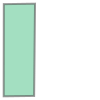

In [17]:
from osgeo import gdal, ogr, osr
from shapely import wkt
wgs_srs = osr.SpatialReference()
wgs_srs.SetWellKnownGeogCS('WGS84')
def xml2wkt(xml_fn):
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_fn)
    #There's probably a cleaner way to do this with a single array instead of zipping
    taglon = ['ULLON', 'URLON', 'LRLON', 'LLLON']
    taglat = ['ULLAT', 'URLAT', 'LRLAT', 'LLLAT']
    #dg_mosaic.py doesn't preserve the BAND_P xml tags 
    #However, these are preserved in the STEREO_PAIR xml tags
    #taglon = ['ULLON', 'LRLON', 'LRLON', 'ULLON']
    #taglat = ['ULLAT', 'ULLAT', 'LRLAT', 'LRLAT']
    x = []
    y = []
    for tag in taglon:
        elem = tree.find('.//%s' % tag)
        #NOTE: need to check to make sure that xml has these tags (dg_mosaic doesn't preserve)
        x.append(elem.text)
    for tag in taglat:
        elem = tree.find('.//%s' % tag)
        y.append(elem.text)
    #Want to complete the polygon by returning to first point
    x.append(x[0])
    y.append(y[0])
    geom_wkt = 'POLYGON(({0}))'.format(', '.join(['{0} {1}'.format(*a) for a in zip(x,y)]))
    return geom_wkt

def geom_union(geom_list, **kwargs):
    convex=False
    union = geom_list[0]
    for geom in geom_list[1:]:
        union = union.Union(geom)
    if convex:
        union = union.ConvexHull()
    return union

def xml2geom(xml_fn):
    """
    Get OGR Geometry object
    """
    geom_wkt = xml2wkt(xml_fn)
    geom = ogr.CreateGeometryFromWkt(geom_wkt)
    #Hack for GDAL3, should reorder with (lat,lon) as specified
    if int(gdal.__version__.split('.')[0]) >= 3:
        wgs_srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    geom.AssignSpatialReference(wgs_srs)
    return geom

def ogr2shapely(geom):
    return wkt.loads(geom.ExportToWkt())

xml_fn = toa_list[0].replace('tif','xml')
ogr2shapely(xml2geom(xml_fn))

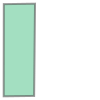

In [19]:
def xml2poly(xml_fn):
    """
    Get Shapely Polygon object
    """
    geom_wkt = xml2wkt(xml_fn)
    return wkt.loads(geom_wkt)
xml2poly(xml_fn)

### Summarize the footprints gdf

In [7]:
#footprint_gdf = gpd.read_file('/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/footprints_srlite-0.9.9.gpkg')
footprint_gdf['batch_name'] = footprint_gdf['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
footprint_gdf[footprint_gdf.batch_name == 'Howland-WV02'].total_bounds
#footprint_gdf.bounds

array([nan, nan, nan, nan])

In [27]:
print(f"Total # of {d['data_source'] } files:  {footprint_gdf.shape[0]}")
footprint_gdf[['footprint_name','batch_name','path']].groupby(['batch_name','footprint_name']).count()


Total # of Cloudmask files:  336


path
batch_name     footprint_name      
Alaska         GE01              26
               QB02               4
               WV02             122
               WV03              21
Fairbanks      WV02               9
               WV03               3
Howland        GE01               4
               WV02               7
               WV03               1
Laselva        GE01               7
               QB02               8
RailroadValley WV02              50
Senegal        WV02              27
               WV03               3
Siberia        WV02              25
               WV03               2
Whitesands     QB02               8
               WV02               7
Yukon_Delta    WV02               2

## Check all footprints

In [12]:
FOOTPRINT_TYPE_LIST = ['EVHR','ccdc_v20220620','Cloudmask']
smry_df_list = []
footprint_gdf_LIST = []
for i,TYPE in enumerate(FOOTPRINT_TYPE_LIST):
    footprint_fn = f"{dict_list[i]['out_footprint_dir']}/footprints_{TYPE}.gpkg"
    print(footprint_fn)
    footprint_gdf_TYPE = gpd.read_file(footprint_fn)
    
    print(f"Total # of {dict_list[i]['data_source'] } files:  {footprint_gdf_TYPE.shape[0]}")
    
    footprint_gdf_TYPE = footprint_gdf_TYPE[~footprint_gdf_TYPE.file.str.contains("_P1BS_")]
    print(f"Total # of {dict_list[i]['data_source'] } M1BS files:  {footprint_gdf_TYPE.shape[0]}")
    
    footprint_gdf_TYPE['footprint_type'] = TYPE
    footprint_gdf_TYPE['batch_name'] = footprint_gdf_TYPE['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    footprint_gdf_TYPE['sensor'] = footprint_gdf_TYPE['file'].str.split('_', expand=True)[0]
    footprint_gdf_LIST.append(footprint_gdf_TYPE)
    #print(footprint_gdf_TYPE[['file','batch_name','path','footprint_type']].groupby(['footprint_type']).count())
    smry_df = footprint_gdf_TYPE[['file','batch_name','path','footprint_type']].groupby(['batch_name','path','footprint_type']).count()
    smry_df_list.append(smry_df)
    
footprint_gdf_ALL = pd.concat(footprint_gdf_LIST)    
smry_df = pd.concat(smry_df_list)
smry_df_fn = '/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/footprint_smry.csv'
print(f"Summary file: {smry_df_fn}")
smry_df.to_csv(smry_df_fn)
smry_df

/explore/nobackup/projects/ilab/data/srlite/toa/footprints_EVHR.gpkg
Total # of EVHR files:  367
Total # of EVHR M1BS files:  367
/explore/nobackup/projects/ilab/data/srlite/ccdc/footprints_ccdc_v20220620.gpkg
Total # of ccdc_v20220620 files:  452
Total # of ccdc_v20220620 M1BS files:  452
/explore/nobackup/projects/ilab/data/srlite/cloudmask/footprints_Cloudmask.gpkg
Total # of Cloudmask files:  336
Total # of Cloudmask M1BS files:  336
Summary file: /adapt/nobackup/people/pmontesa/userfs02/projects/srlite/footprint_smry.csv


,,,file
batch_name,path,footprint_type,
Alaska,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska,EVHR,176
Howland,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Howland,EVHR,12
Laselva,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Laselva,EVHR,15
RailroadValley,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/RailroadValley,EVHR,50
Senegal,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Senegal,EVHR,30
Serc,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Serc,EVHR,40
Siberia,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Siberia,EVHR,27
Whitesands,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Whitesands,EVHR,15
Yukon_Delta,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Yukon_Delta,EVHR,2


In [28]:
maplib.MAP_LAYER_FOLIUM(footprint_gdf, LAYER_COL_NAME='file', LAYER_NAME = d['data_source'], zoom_start=6, 
                        #lon_start=footprint_gdf[footprint_gdf.batch_name == 'Senegal'].geometry.centroid.x.mean(), 
                        #lat_start=footprint_gdf[footprint_gdf.batch_name == 'Senegal'].geometry.centroid.y.mean(), 
                        fig_h=350)

In [76]:
maplib.MAP_LAYER_FOLIUM(gpd.read_file('/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/misc/footprints_srlite-0.9.9.gpkg'),
                        LAYER_COL_NAME='file', foliumMap = None, zoom_start=2, lon_start=0, fig_h=350,
                        LAYER_NAME = 'SR-Lite',
                        LAYER_STYLE_DICT = {'fillColor': 'black', 'color': 'blue', 'weight' : 0.75, 'opacity': 1, 'fillOpacity': 0.5})